In [1]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import os
import numpy as np

carpetas_path = "/kaggle/input/flores-uninorte"

datos_aves = []
for carpeta in os.listdir(carpetas_path):
    path = f"{carpetas_path}/{carpeta}/"
    for element in os.listdir(path):
        df = pd.read_csv(f"{carpetas_path}/{carpeta}/{element}")
        datos_aves.append(df)
        
df_final = pd.concat(datos_aves, axis = 0).reset_index(drop = True)

In [2]:
df_final.iloc[df_final[(df_final["taxon_species_name"] == "Bougainvillea glabra") | (df_final["taxon_species_name"] == "Bougainvillea spectabilis")].index, -5] = "Bougainvillea"

(375, 500, 3)


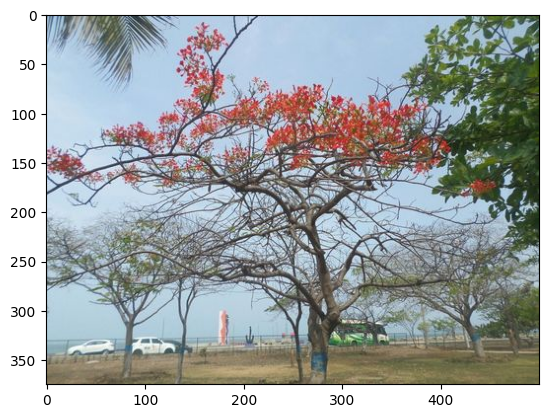

In [3]:
from matplotlib import pyplot as plt

url = df["image_url"][0]
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img_array = np.array(img)
plt.imshow(img_array)

print(img_array.shape)


In [4]:
data = df_final[["image_url","taxon_species_name"]].dropna()

In [5]:
data.iloc[:, 1].value_counts()

taxon_species_name
Handroanthus chrysanthus    1234
Tabebuia rosea               621
Plumeria alba                444
Bougainvillea                417
Delonix regia                188
Name: count, dtype: int64

# Pytorch Models

In [6]:
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import torch
from torch import nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import warnings
from sklearn.model_selection import train_test_split as tts

warnings.filterwarnings("ignore")

In [7]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter()]), p=0.1),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.RandomErasing(p=0.2, value='random')
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


class FlowerDataset(Dataset):
    
    def __init__(self, df, transform = None, Test_mode = False):
        
        self.df = df.reset_index(drop = True)
        self.path = self.df.iloc[:, 0]
        
        self.test_mode = Test_mode
        if self.test_mode == False:
            self.target = self.df.iloc[:, 1]
        self.transform = transform
        
    def __getitem__(self, index):
        
        url = self.path[index]
        response = requests.get(url)
        img = Image.open(BytesIO(response.content)).convert("RGB")

        
        if transform is not None:
            
            img = transform(img)
            
        target = self.target[index]
        
        
        if self.test_mode == False:
            
            return img, target
        else:
            return img
       
    
    def __len__(self):
        
        return len(self.path)

In [8]:
label_encoder = LabelEncoder()
data.iloc[:, 1] = label_encoder.fit_transform(data.iloc[:, 1])

# Mostrar los nombres de las clases y sus correspondientes etiquetas numéricas
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Clase: {class_name}, Etiqueta: {i}")

Train, Test = tts(data, test_size = 0.05, stratify = data.iloc[:, 1])
Train, Valid = tts(Train, test_size = 0.1, stratify = Train.iloc[:, 1])

print(f"Train Shape is: {Train.shape}")
print(f"Valid Shape is: {Valid.shape}")
print(f"Test Shape is: {Test.shape}")

print(f"Validation and Test Len is {(Valid.shape[0]  + Test.shape[0]) / data.shape[0] :.2%}")

train_ds = FlowerDataset(Train, transform)
valid_ds = FlowerDataset(Valid, transform_test)
test_ds = FlowerDataset(Test, transform_test)

train_dl = DataLoader(train_ds, batch_size = 32, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = 32, shuffle = False)
test_dl = DataLoader(test_ds, batch_size = 16, shuffle = False)

Clase: Bougainvillea, Etiqueta: 0
Clase: Delonix regia, Etiqueta: 1
Clase: Handroanthus chrysanthus, Etiqueta: 2
Clase: Plumeria alba, Etiqueta: 3
Clase: Tabebuia rosea, Etiqueta: 4
Train Shape is: (2482, 2)
Valid Shape is: (276, 2)
Test Shape is: (146, 2)
Validation and Test Len is 14.53%


In [9]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load efficientnet_b7 weights (best weight)
weights = EfficientNet_B7_Weights.DEFAULT

# Prepare images to feed into efficientnet_b7 model
preprocess = weights.transforms()

# Load efficientnet_b7 model with best weights
efficientnet_model = efficientnet_b7(weights=weights)

# First freeze everything
for param in efficientnet_model.parameters():
    param.requires_grad = False

# Then unfreeze the last few layers of the model for fine-tuning
for param in efficientnet_model.features[5:].parameters():
    param.requires_grad = True

# Number of classes
num_classes = len(data.taxon_species_name.unique())

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #### CONVs
        self.conv_layers = efficientnet_model
        #### Dense
        self.dense_layers = nn.Sequential(
            nn.Linear(1000, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

model = CNN(num_classes)

# Move the model to GPU for increased speed of processing
model = model.to(device)

# Optimizer and Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 177MB/s]


In [10]:
from tqdm import tqdm
criterion = nn.CrossEntropyLoss()

# Training function
def train(model, optimizer, criterion, train_dl, valid_dl, epochs):
    result = []
    val_res = []

    for e in tqdm(range(epochs)):
        model.train()
        total_loss = 0
        total = 0
        correct = 0
        
        for X_train, y_train in train_dl:
            X_train, y_train = X_train.to(device).float(), y_train.to(device).long()
            
            y_pred = model(X_train)
            if isinstance(y_pred, tuple):  # In case of Inception
                y_pred = y_pred[0]
                
            loss = criterion(y_pred, y_train)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            total_loss += loss.item()
            _, predicted = torch.max(y_pred.data, 1)
            total += y_train.size(0)
            correct += (predicted == y_train).sum().item()
            
        acc_train = 100 * correct / total
        _, val_acc = valid(model, valid_dl, device)
        
        print(f'Epoch: [{e+1}/{epochs}], Loss: {total_loss / total:.4f}, Train Acc: {acc_train:.2f}, Val Acc: {val_acc:.2f}')
        result.append(acc_train)
        val_res.append(val_acc)
    
    # Save results to files
    np.savetxt('result.csv', np.array(result), fmt='%.2f', delimiter=',')
    np.savetxt('val_result.csv', np.array(val_res), fmt='%.2f', delimiter=',') 

# Validation Function
def valid(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sample, target in val_loader:
            sample = sample.to(device).float()
            target = target.to(device).long()
            outputs = model(sample)
            _, predicted = torch.max(outputs.data, 1)
            
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_accuracy = 100 * correct / total
    return [], val_accuracy

def plot():
    train_data = np.loadtxt('result.csv', delimiter=',')
    val_data = np.loadtxt('val_result.csv', delimiter=',')
    plt.figure()
    plt.plot(range(1, len(train_data) + 1), train_data, color='blue', label='Train')
    plt.plot(range(1, len(val_data) + 1), val_data, color='red', label='Validation')
    plt.legend()
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.title('Train and Validation Accuracy', fontsize=16)
    plt.savefig('plot.png')
    plt.show()

  7%|▋         | 1/15 [13:20<3:06:40, 800.05s/it]

Epoch: [1/15], Loss: 0.0241, Train Acc: 70.71, Val Acc: 79.71


 13%|█▎        | 2/15 [26:32<2:52:19, 795.37s/it]

Epoch: [2/15], Loss: 0.0157, Train Acc: 82.72, Val Acc: 77.17


 20%|██        | 3/15 [39:46<2:39:00, 795.00s/it]

Epoch: [3/15], Loss: 0.0134, Train Acc: 84.73, Val Acc: 74.28


 27%|██▋       | 4/15 [53:11<2:26:25, 798.70s/it]

Epoch: [4/15], Loss: 0.0117, Train Acc: 87.27, Val Acc: 75.36


 33%|███▎      | 5/15 [1:06:27<2:12:59, 797.97s/it]

Epoch: [5/15], Loss: 0.0094, Train Acc: 89.44, Val Acc: 78.99


 40%|████      | 6/15 [1:19:38<1:59:18, 795.42s/it]

Epoch: [6/15], Loss: 0.0082, Train Acc: 91.34, Val Acc: 79.71


 47%|████▋     | 7/15 [1:32:46<1:45:44, 793.09s/it]

Epoch: [7/15], Loss: 0.0076, Train Acc: 91.94, Val Acc: 85.14


 53%|█████▎    | 8/15 [1:45:57<1:32:26, 792.42s/it]

Epoch: [8/15], Loss: 0.0071, Train Acc: 92.10, Val Acc: 82.61


 60%|██████    | 9/15 [1:59:12<1:19:20, 793.36s/it]

Epoch: [9/15], Loss: 0.0061, Train Acc: 93.27, Val Acc: 78.62


 67%|██████▋   | 10/15 [2:12:32<1:06:16, 795.38s/it]

Epoch: [10/15], Loss: 0.0067, Train Acc: 92.30, Val Acc: 84.06


 73%|███████▎  | 11/15 [2:25:40<52:52, 793.11s/it]  

Epoch: [11/15], Loss: 0.0042, Train Acc: 95.53, Val Acc: 85.14


 80%|████████  | 12/15 [2:38:51<39:37, 792.34s/it]

Epoch: [12/15], Loss: 0.0044, Train Acc: 95.77, Val Acc: 82.97


 87%|████████▋ | 13/15 [2:52:16<26:32, 796.31s/it]

Epoch: [13/15], Loss: 0.0047, Train Acc: 95.12, Val Acc: 83.33


 93%|█████████▎| 14/15 [3:06:09<13:27, 807.20s/it]

Epoch: [14/15], Loss: 0.0046, Train Acc: 95.73, Val Acc: 86.59


100%|██████████| 15/15 [3:19:53<00:00, 799.58s/it]

Epoch: [15/15], Loss: 0.0030, Train Acc: 96.66, Val Acc: 82.61


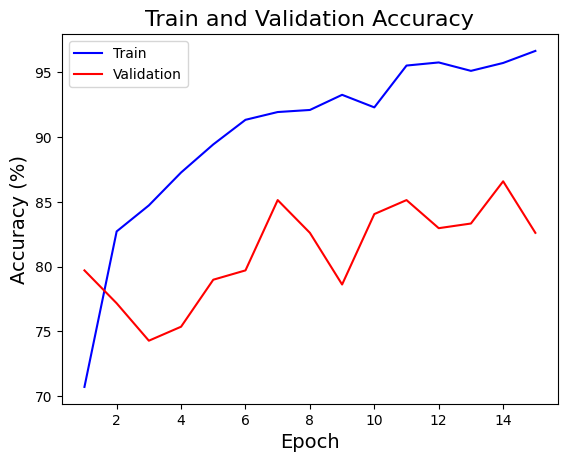

In [11]:
train(model, optimizer, criterion, train_dl, valid_dl, 15)
plot()

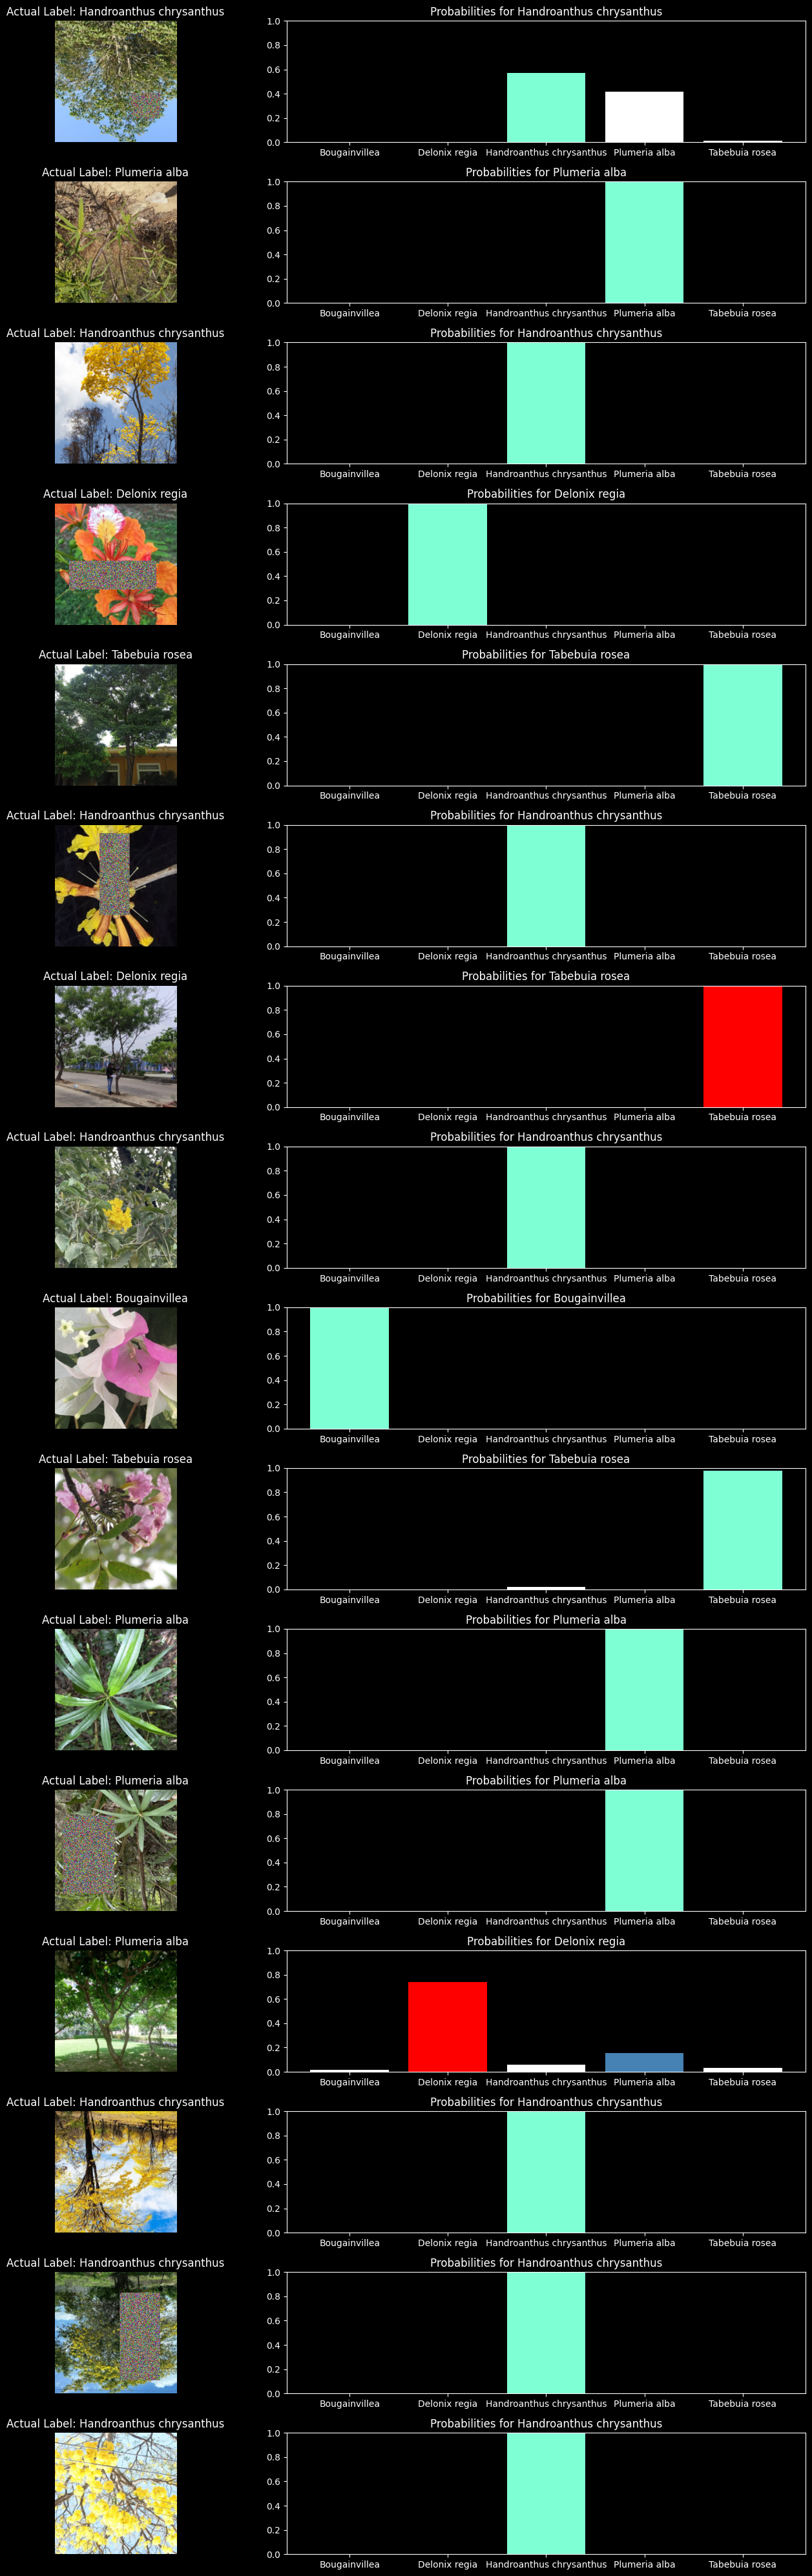

In [12]:
# Valores de normalización comúnmente utilizados para imágenes RGB en PyTorch
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Función para desnormalizar una imagen
def denormalize(image, mean, std):
    image = image.clone()  # Crear una copia para no modificar el original
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)  # Desnormalizar
    return image

# Ejemplo: obtener un batch de datos
images, targets = next(iter(test_dl))  
indices = np.arange(len(images))
np.random.shuffle(indices)

fig, axes = plt.subplots(16, 2, figsize=(15, 40))  # 16 filas y 2 columnas (imagen y gráfico de barras)
axes = axes.ravel()

# Establecer el color de fondo negro para todos los subplots
for ax in axes:
    ax.set_facecolor('black')

# Establecer el color de fondo negro para todo el gráfico
fig.patch.set_facecolor('black')

# Invertir el diccionario de LabelEncoder para mapear enteros a etiquetas
int_to_label = {i: label for i, label in enumerate(label_encoder.classes_)}

# Cálculo de precisión
correct_predictions = {label: 0 for label in int_to_label.values()}
total_predictions = {label: 0 for label in int_to_label.values()}

# Limitar el número de iteraciones a la cantidad de subplots disponibles
for i in range(min(len(indices), len(axes) // 2)):
    idx = indices[i]
    image, actual_target = images[idx], targets[idx]
    image_tensor = image.to(device).unsqueeze(0)
    output = model(image_tensor)
    _, prediction = torch.max(output, 1)
    
    predicted_label = int_to_label[prediction.cpu().item()]  # Convertir a nombre de clase
    actual_label = int_to_label[actual_target.item()]
    total_predictions[actual_label] += 1
    if predicted_label == actual_label:
        correct_predictions[predicted_label] += 1
    
    # Convertir el tensor de imagen para graficar
    image = denormalize(image, mean, std)
    image = image.permute(1, 2, 0)  # Cambiar dimensiones de CxHxW a HxWxC
    image = image.cpu().numpy()
    
    # Mostrar imagen
    axes[2 * i].imshow(image)
    axes[2 * i].set_title(f"Actual Label: {actual_label}", color='white')
    axes[2 * i].axis('off')
    
    # Mostrar gráfico de barras con probabilidades
    probabilities = torch.nn.functional.softmax(output, dim=1).cpu().detach().numpy().flatten()
    bar_colors = ['white'] * len(probabilities)  # Colores por defecto
    
    # Cambiar colores de las barras según condiciones
    if predicted_label == actual_label:
        bar_colors[np.argmax(probabilities)] = 'aquamarine'  # Predicción correcta
    else:
        bar_colors[np.argmax(probabilities)] = 'red'  # Predicción incorrecta
        bar_colors[list(int_to_label.values()).index(actual_label)] = 'steelblue'  # Etiqueta correcta
    
    axes[2 * i + 1].bar(int_to_label.values(), probabilities, color=bar_colors)
    axes[2 * i + 1].set_ylim(0, 1)
    axes[2 * i + 1].set_title(f"Probabilities for {predicted_label}", color='white')
    
    # Configurar colores de los ejes y anotaciones
    axes[2 * i + 1].tick_params(axis='x', colors='white')
    axes[2 * i + 1].tick_params(axis='y', colors='white')
    axes[2 * i + 1].spines['bottom'].set_color('white')
    axes[2 * i + 1].spines['top'].set_color('white') 
    axes[2 * i + 1].spines['right'].set_color('white')
    axes[2 * i + 1].spines['left'].set_color('white')
    axes[2 * i + 1].yaxis.label.set_color('white')
    axes[2 * i + 1].xaxis.label.set_color('white')

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

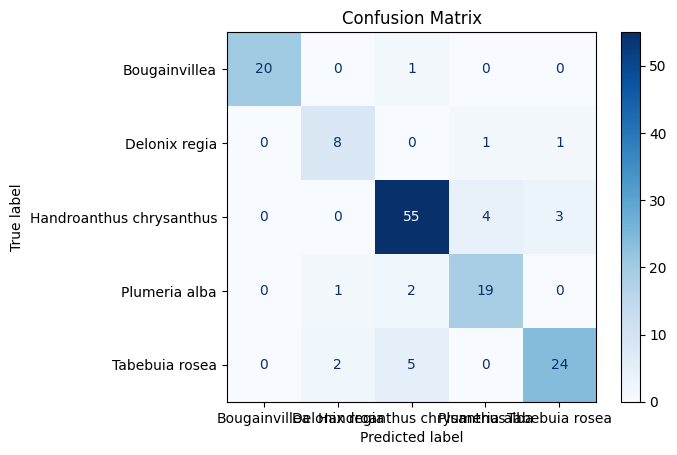

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Función para calcular la matriz de confusión
def plot_confusion_matrix(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calcular la matriz de confusión
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
    
    # Mostrar la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=int_to_label.values())
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Llamar a la función para mostrar la matriz de confusión
plot_confusion_matrix(model, test_dl, device)

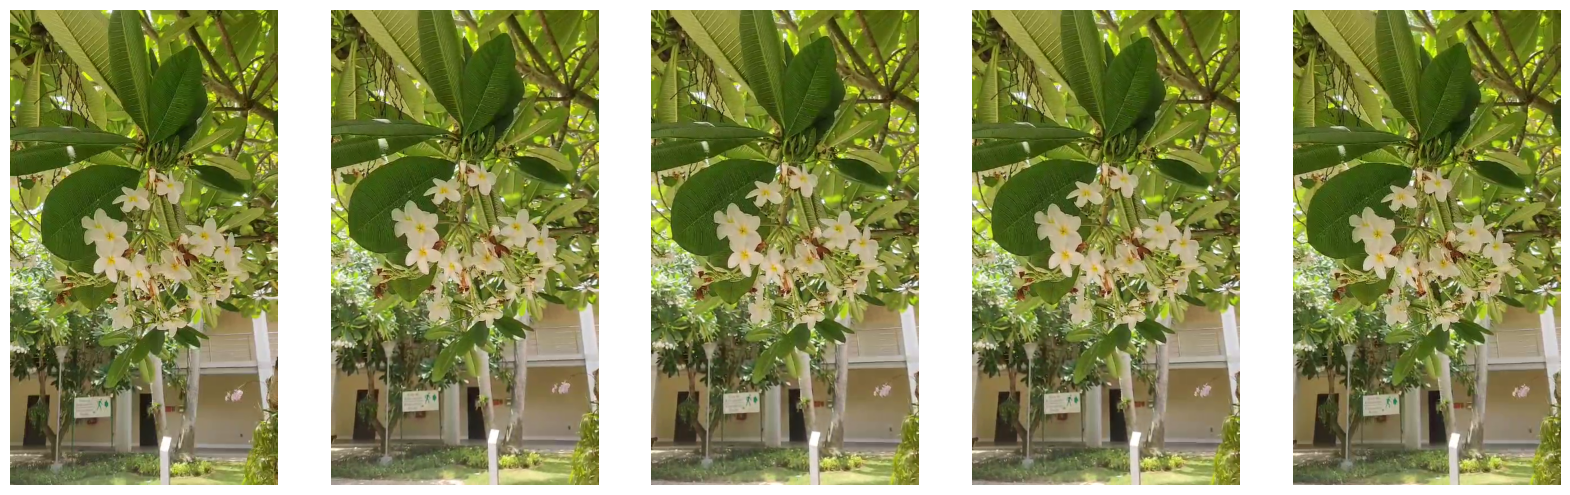

In [14]:
import cv2
import matplotlib.pyplot as plt
import random

# Ruta del video
video_path = "/kaggle/input/test-data/WhatsApp Video 2024-08-05 at 1.45.00 PM.mp4"

# Cargar el video
cap = cv2.VideoCapture(video_path)

# Obtener el número total de frames en el video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Seleccionar 5 números de frames aleatorios únicos
random_frames = random.sample(range(total_frames), 5)

# Inicializar un array para almacenar los frames seleccionados
selected_frames = []

# Extraer y almacenar los frames seleccionados
for i in range(total_frames):
    ret, frame = cap.read()
    if not ret:
        break
    if i in random_frames:
        selected_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convertir de BGR a RGB para mostrar correctamente con matplotlib

# Liberar el video
cap.release()

# Visualizar los 5 frames seleccionados
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
for idx, frame in enumerate(selected_frames):
    axes[idx].imshow(frame)
    axes[idx].axis('off')

plt.show()


In [15]:
from PIL import Image

# Mover el modelo a la GPU
model.eval()  # Cambiar el modelo a modo de evaluación

predicciones = []
for frame in selected_frames:
    # Convertir el frame de NumPy array a PIL Image
    pil_image = Image.fromarray(frame)
    
    # Preprocesar cada frame
    input_tensor = transform_test(pil_image).unsqueeze(0).to(device)
    
    # Realizar la predicción
    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)
        predicciones.append(pred.item())


predicciones_texto = label_encoder.inverse_transform(predicciones)

# Mostrar las predicciones convertidas a texto
print(predicciones_texto)

['Plumeria alba' 'Plumeria alba' 'Plumeria alba' 'Plumeria alba'
 'Plumeria alba']
